In [1]:
from bs4 import BeautifulSoup
import requests
import os
# https://data.binance.vision/?prefix=data/spot/monthly/klines/
# https://github.com/binance/binance-public-data

In [6]:
url = "https://data.binance.vision/?prefix=data/spot/monthly/klines/1INCHBTC/1m/"

with open("/home/ema/dev/shocks/data/binance_pairs.html") as file:
    soup = BeautifulSoup(file)

In [7]:
pairs = []
for pair in soup.find_all("a")[1: ]:
    pairs.append(pair.text.replace("/", ""))

def download_data(data_path, pair, months, freq="1m"):
    for month in months:
        pair_dir = os.path.join(DATA_PATH, pair)
        if not os.path.isdir(pair_dir):
            os.mkdir(pair_dir)

        url = f"https://data.binance.vision/data/spot/monthly/klines/{pair}/{freq}/{pair}-{freq}-{month}.zip"
        os.system(f" cd {pair_dir} && wget {url}")
 

In [44]:
months = [
    "2021-10",
    "2021-11",
    "2021-12",
    "2022-01",
    "2022-02",
    "2022-03",
]

freq = "1m"
DATA_PATH ="/home/ema/dev/shocks/shocks/data/binance/"
selected_pairs = ("BTCUSDT", "BNBBTC", "AVAXBTC", "JOEBTC", "AXSTRY", "CAKEBRL")


for pair in selected_pairs:
    download_data(data_path=DATA_PATH, pair=pair, months=months, freq="1m")

NameError: name 'download_data' is not defined

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
from shocks.dataset import Dataset
import pandas as pd
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams["figure.figsize"] = (20,15)

data = Dataset(pair="AVAXBTC")
data.preprocess(freq="5m")

In [ ]:
data.find_shocks(start_date="2021-10-01", end_date="2021-10-04", plot=False, std_from_mean=3.5)
data.fit(window=100, start_date="2021-10-01", end_date="2021-10-04")
plot(data.fitted, data.shocks, cols="returns close alpha beta".split())

In [4]:
import matplotlib.dates as mdates
def plot(df, shocks=None, cols = ["returns", "close"]):
    fig, axs = plt.subplots(len(cols))
    fig.suptitle('BTC/USD')
    df = df.dropna()
    for idx, key in enumerate(cols):
        axs[idx].plot(df[key])
        axs[idx].set_title(key)
        axs[idx].grid(True)
    
        if shocks is not None:
            #trans = axs.get_xaxis_transform()
            for i, shock in enumerate(shocks):
                axs[idx].axvline(shock["start"], alpha=0.5, color="red")
                axs[idx].axvline(shock["end"], alpha=0.5, color="red")
                label_position = 0.5 if i%2 == 0 else -0.5
                #plt.text(shock["start"], label_position, s="diocane")#, str(shock["duration"]))
    plt.show()

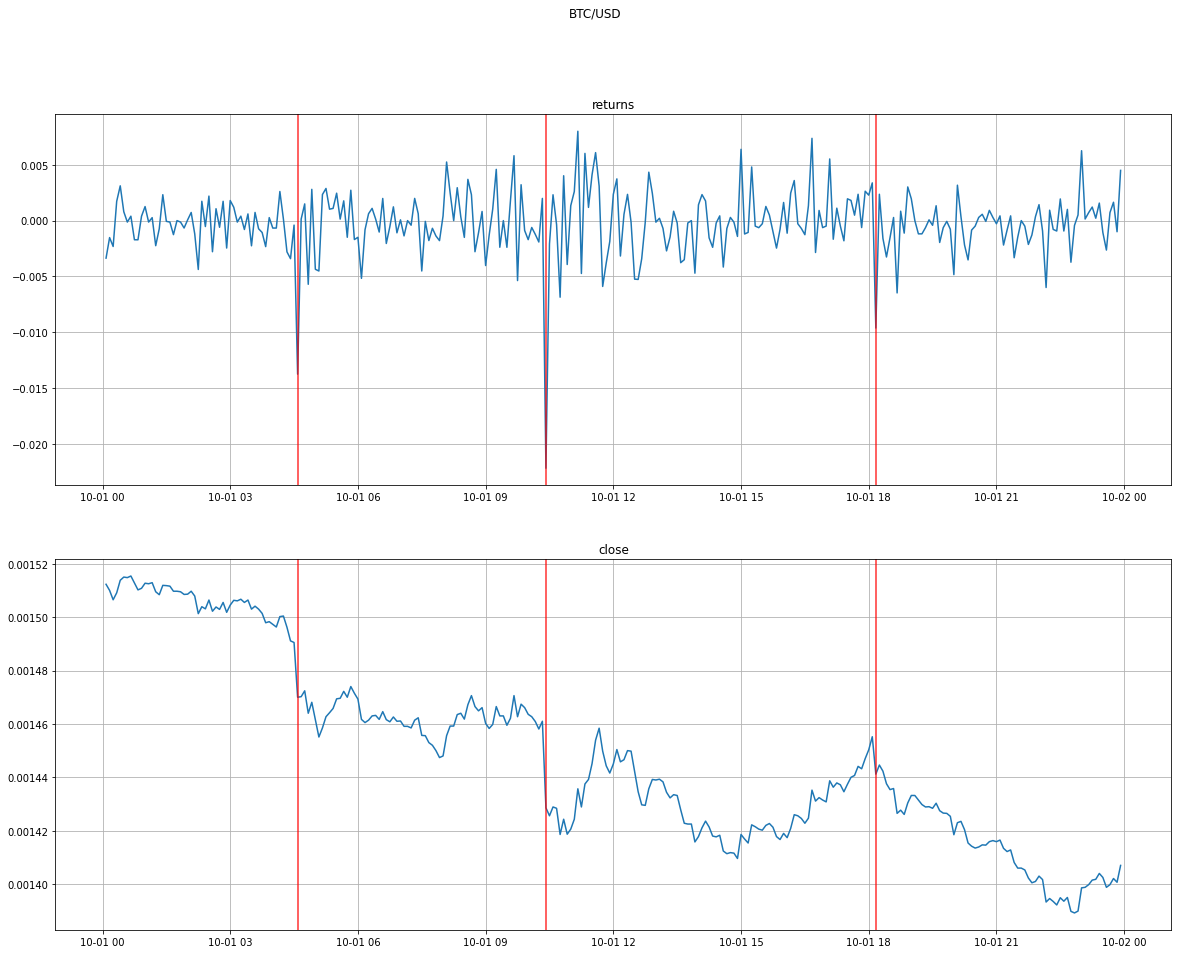

In [15]:
cols = ["returns", "close"]
df = Dataset.filter_data(df=data.data.dropna(),start_date="2021-10-01", end_date="2021-10-02")
plot(df, data.shocks[:3])


Ciao, sono Emanuele e ti scrivo perché sono interessato ad un'opportunità di lavoro a Google. Penso di essere qualificato per i seguenti ruoli: 

e mi sarebbe di grande aiuto se potessi farmi una reference. Mi sto per laureare e ho quasi due anni di esperienza alle spalle come software engineer/machine learning engineer. 

Grazie mille, e buona giornata. 

Emanuele. 